In [1]:
# Use autoreload magic
%load_ext autoreload
%autoreload 2

import numpy as np
import mcmc_infinity as mc
import matplotlib.pyplot as plt
import seaborn as sns

seed = 12345

# Plot the Target Density

For this example we use the two-dimensional Rastrigrin function.

In [57]:
dim = 2

target = mc.test_functions.rosenbrock.Rosenbrock(dim)

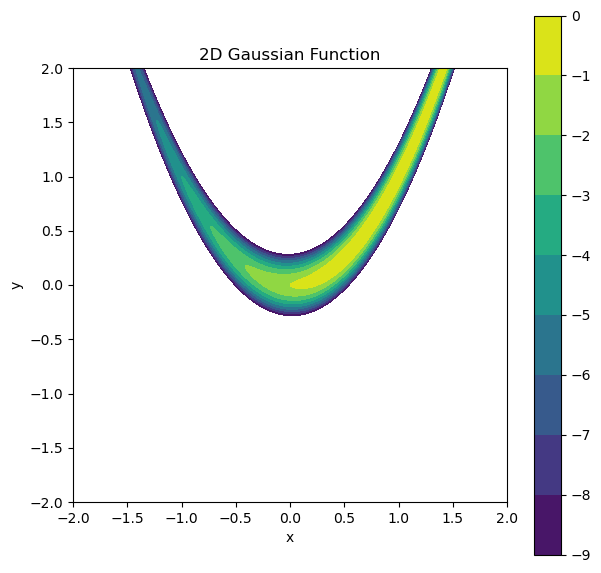

In [60]:
x = np.linspace(-2.0, 2.0, 300)
y = np.linspace(-2.0, 2.0, 300)
X, Y = np.meshgrid(x, y)
Z = target(np.stack((X, Y), axis=-1))

fig, ax = plt.subplots(figsize=(7, 7))
cf = ax.contourf(X, Y, Z, levels=np.linspace(-9, 0, 10))
cbar = plt.colorbar(cf)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("2D Gaussian Function")
ax.set_aspect('equal')
plt.show()

# Regular MCMC

In [61]:
import emcee

Acceptance rate: 0.601


Text(0, 0.5, 'y')

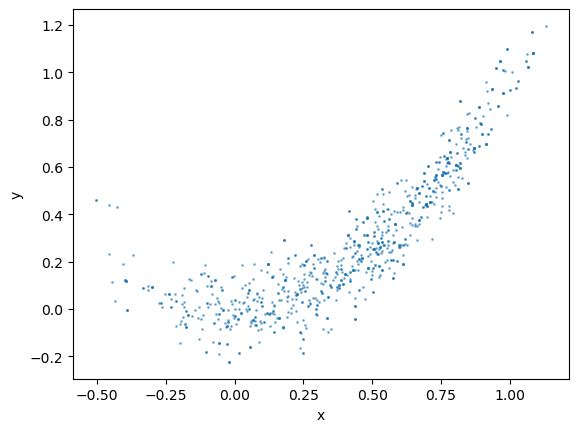

In [62]:
bounds = [[-2., 2.], [-2., 2.]]

x0 = [[0.0, 0.0]]

Q = mc.symmetric_gaussian_proposal.SymmetricGaussianProposal(dim, bounds=bounds)

sampler = mc.sampler.PerfectSampler(target, Q, x0, seed=seed, 
                                    proposal_kwargs={'sigma': 0.1})

samples, acceptance = sampler.evolve_chain(x0[0], 1_000)

print(f"Acceptance rate: {acceptance}")

plt.scatter(samples[:, 0], samples[:, 1], s=1, alpha=0.5)
plt.xlabel("x")
plt.ylabel("y")


## 'True' samples

In [82]:
n_samples = 1000
n_accepted = 0
samples = np.empty((0, dim))
rng = np.random.default_rng(seed)
xy = rng.uniform(-2, 2, size=(100_000, dim))
log_weights = target(xy)
log_weights -= np.max(log_weights)  # for numerical stability
log_u = np.log(rng.uniform(size=len(xy)))
iid_samples = xy[log_u < log_weights]

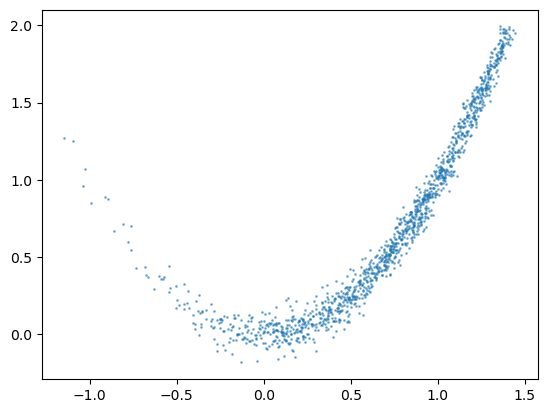

In [85]:
plt.scatter(iid_samples[:, 0], iid_samples[:, 1], s=1, alpha=0.5, label='IID Samples')
plt.show()

# Proposal

The perfect MCMC sampler works with a common proposal.
The user must provide this. 
Here we use a uniform proposal in the range $(-5.12, 5.12)$ along each dimension.

The proposal distribution is denoted $Q$.

 16%|█▌        | 79/500 [00:01<00:10, 41.31it/s, train=-0.0835, val=0.0101 (Max patience reached)]


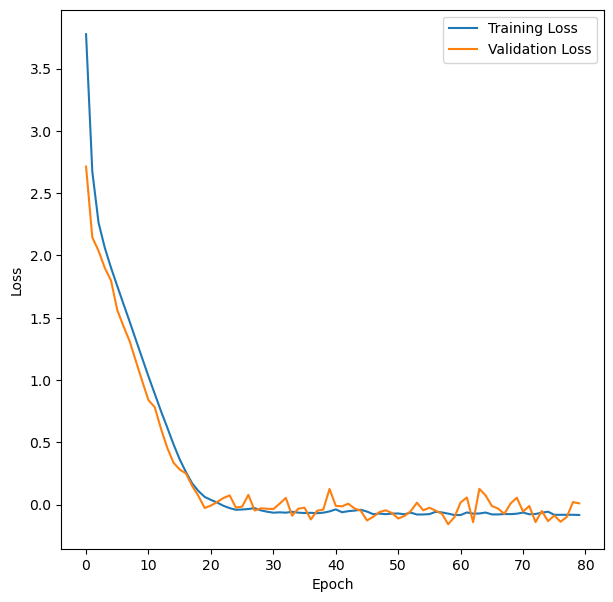

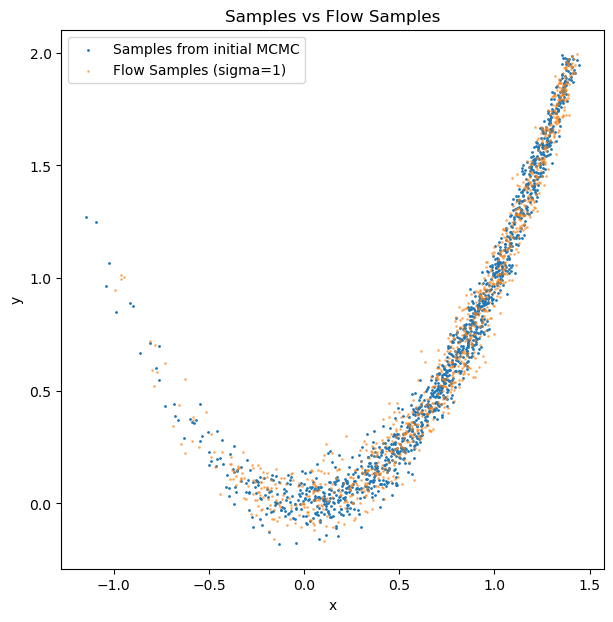

In [104]:
import jax
flow_key, fit_key, samples_key = jax.random.split(jax.random.key(seed), 3)
proposal = mc.normalizing_flow_proposal.NormalizingFlowProposal(
   dim, bounds=bounds, key=flow_key, flow_layers=4, nn_width=32,
)

init_key = jax.random.key(seed + 10)
# samples = 1.2 * jax.random.normal(init_key, (1000, dim))

losses = proposal.fit(
    iid_samples,
    key=fit_key,
    max_epochs=500,
    batch_size=100,
    max_patience=20,
    learning_rate=0.001,
)

fig = plt.figure(figsize=(7, 7))
plt.plot(losses['train'], label='Training Loss')
plt.plot(losses['val'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

flow_samples = proposal.sample(samples_key, num_samples=1000)

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(iid_samples[:, 0], iid_samples[:, 1], s=1, label='Samples from initial MCMC')
ax.scatter(flow_samples[:, 0], flow_samples[:, 1], s=1, label='Flow Samples (sigma=1)', alpha=0.5)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Samples vs Flow Samples")
ax.legend()
plt.show()

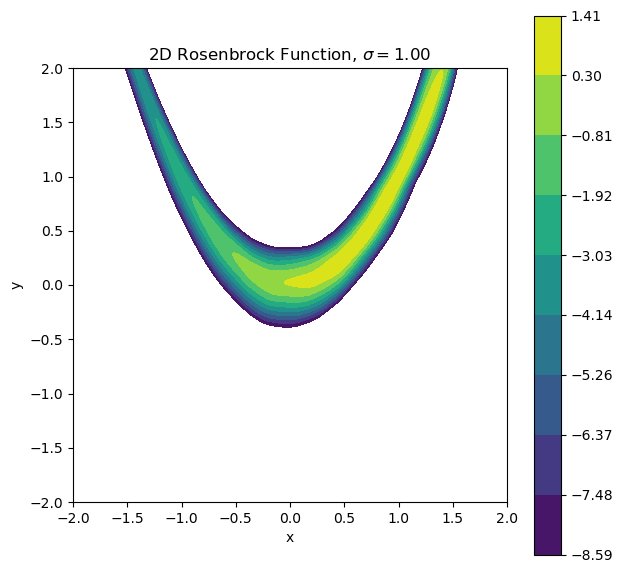

In [102]:

proposal.set_flow_annealing(scale=1.0)
assert proposal.flow_scale == 1.0, "Flow scale should be 1.0 before annealing."
Z = proposal(np.stack((X, Y), axis=-1))
# Z = Z - np.max(Z)  # Shift to make the minimum zero
# Z = np.clip(Z, -100, None)  # Ensure non-negative values for contour plot
fig, ax = plt.subplots(figsize=(7, 7))
cf = ax.contourf(X, Y, Z, levels=np.linspace(Z.max() - 10, Z.max(), 10))
cbar = plt.colorbar(cf)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title(rf"2D Rosenbrock Function, $\sigma={proposal.flow_scale:.2f}$")
ax.set_aspect('equal')
plt.show()

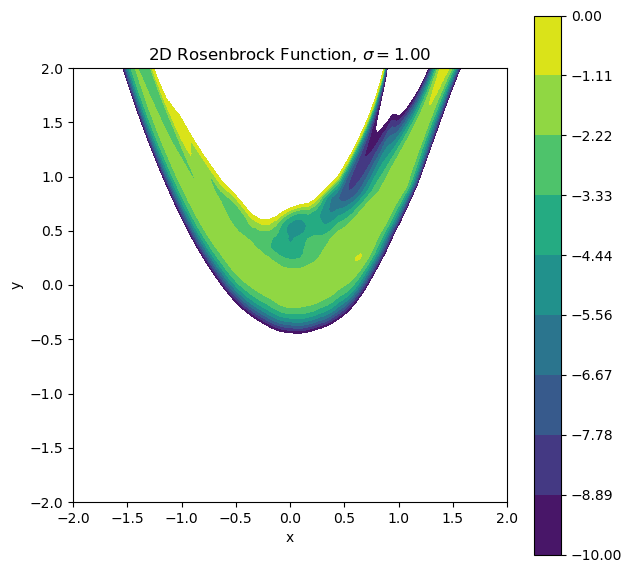

In [103]:

proposal.set_flow_annealing(scale=1.0)
assert proposal.flow_scale == 1.0, "Flow scale should be 1.0 before annealing."
Z = target(np.stack((X, Y), axis=-1)) - proposal(np.stack((X, Y), axis=-1))
# Z = Z - np.max(Z)  # Shift to make the minimum zero
# Z = np.clip(Z, -100, None)  # Ensure non-negative values for contour plot
fig, ax = plt.subplots(figsize=(7, 7))
cf = ax.contourf(X, Y, Z, levels=np.linspace(-10, 0, 10))
cbar = plt.colorbar(cf)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title(rf"2D Rosenbrock Function, $\sigma={proposal.flow_scale:.2f}$")
ax.set_aspect('equal')
plt.show()

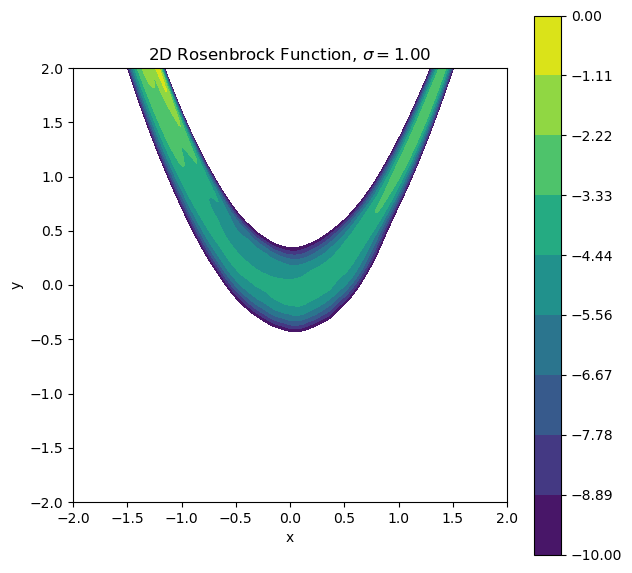

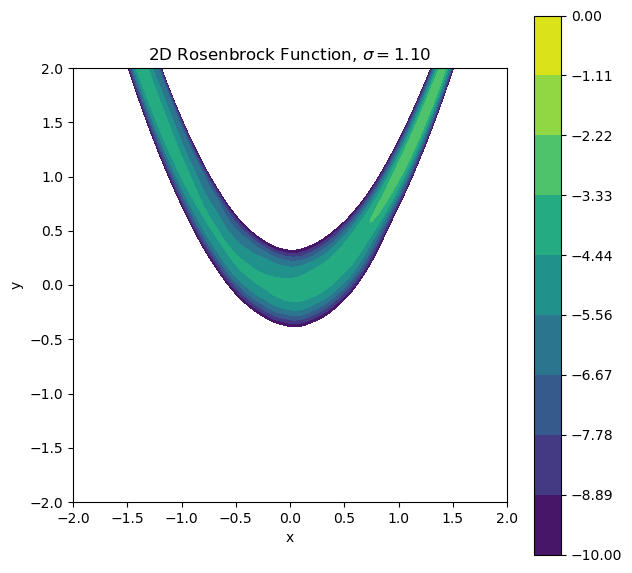

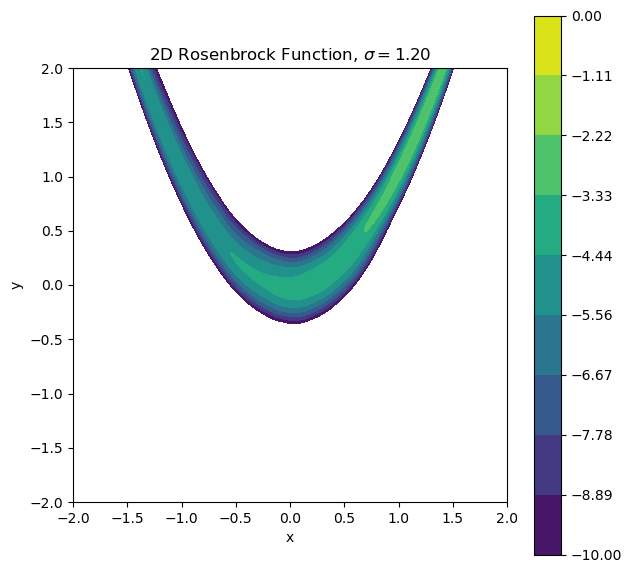

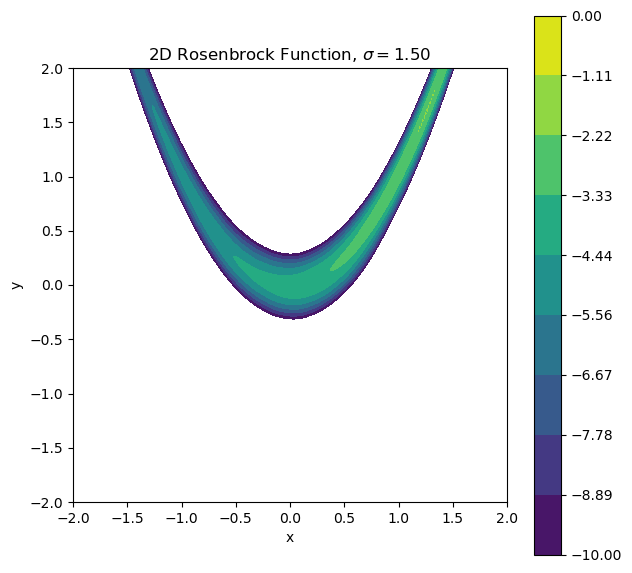

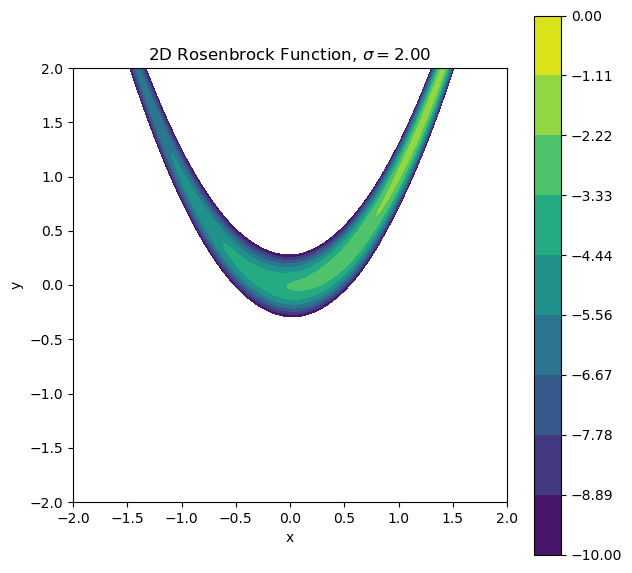

In [94]:
# proposal.set_flow_annealing(scale=1.0)
for scale in [1.0, 1.1, 1.2, 1.5, 2.0]:
    proposal.set_flow_annealing(scale=scale)
    Z = target(np.stack((X, Y), axis=-1)) - proposal(np.stack((X, Y), axis=-1))
    fig, ax = plt.subplots(figsize=(7, 7))
    cf = ax.contourf(X, Y, Z, levels=np.linspace(-10, 0, 10))
    cbar = plt.colorbar(cf)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(rf"2D Rosenbrock Function, $\sigma={proposal.flow_scale:.2f}$")
    ax.set_aspect('equal')
    plt.show()

# Initialise the Sampler

In [77]:
x0 = [[0.0, 0.0], [-2, -2]]

# proposal = mc.uniform_proposal.UniformProposal(dim, bounds=bounds)
# proposal.set_flow_annealing(scale=1.05)
sampler = mc.sampler.PerfectSampler(target, proposal, x0, seed=seed)

# A Perfect Sample

The following plot illustrates the "binary stepping back" idea of Propp & Wilson
for obtaining a perfect sample from the target distribution.

sample, all_output = sampler.get_perfect_sample(2, show_all_output=True)

In [81]:
sample, all_output = sampler.get_perfect_sample(2, show_all_output=True, verbose=True)

Trying T=2 steps...


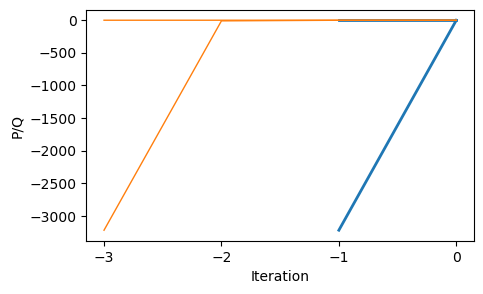

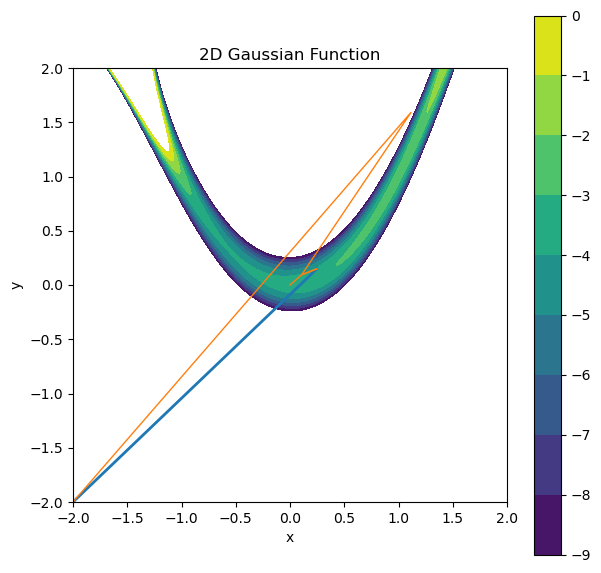

In [79]:
fig, ax = plt.subplots(figsize=(5,3))

for i, chains in enumerate(all_output):
    chain0 = chains[0]
    chain1 = chains[1]

    y0 = target(chain0)-proposal(chain0)
    y1 = target(chain1)-proposal(chain1)

    x = np.arange(1-len(y0), 1)

    lw = len(all_output)-i

    ax.plot(x, y0, color='C{}'.format(i), lw=lw)
    ax.plot(x, y1, color='C{}'.format(i), lw=lw)

ax.set_xticks(x)
ax.set_xlabel('Iteration')
ax.set_ylabel('P/Q')
plt.show()


fig, ax = plt.subplots(figsize=(7, 7))

for i, chains in enumerate(all_output):
    chain0 = chains[0]
    chain1 = chains[1]
    lw = len(all_output)-i
    ax.plot(chain0[:, 0], chain0[:, 1], color='C{}'.format(i), lw=lw)
    ax.plot(chain1[:, 0], chain1[:, 1], color='C{}'.format(i), lw=lw)

cf = ax.contourf(X, Y, Z, levels=np.linspace(-9, 0, 10))
cbar = plt.colorbar(cf)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("2D Gaussian Function")
ax.set_aspect('equal')
plt.show()

# Perfect Sampling

We can now repeat this to get as many i.i.d perfect samples as required.

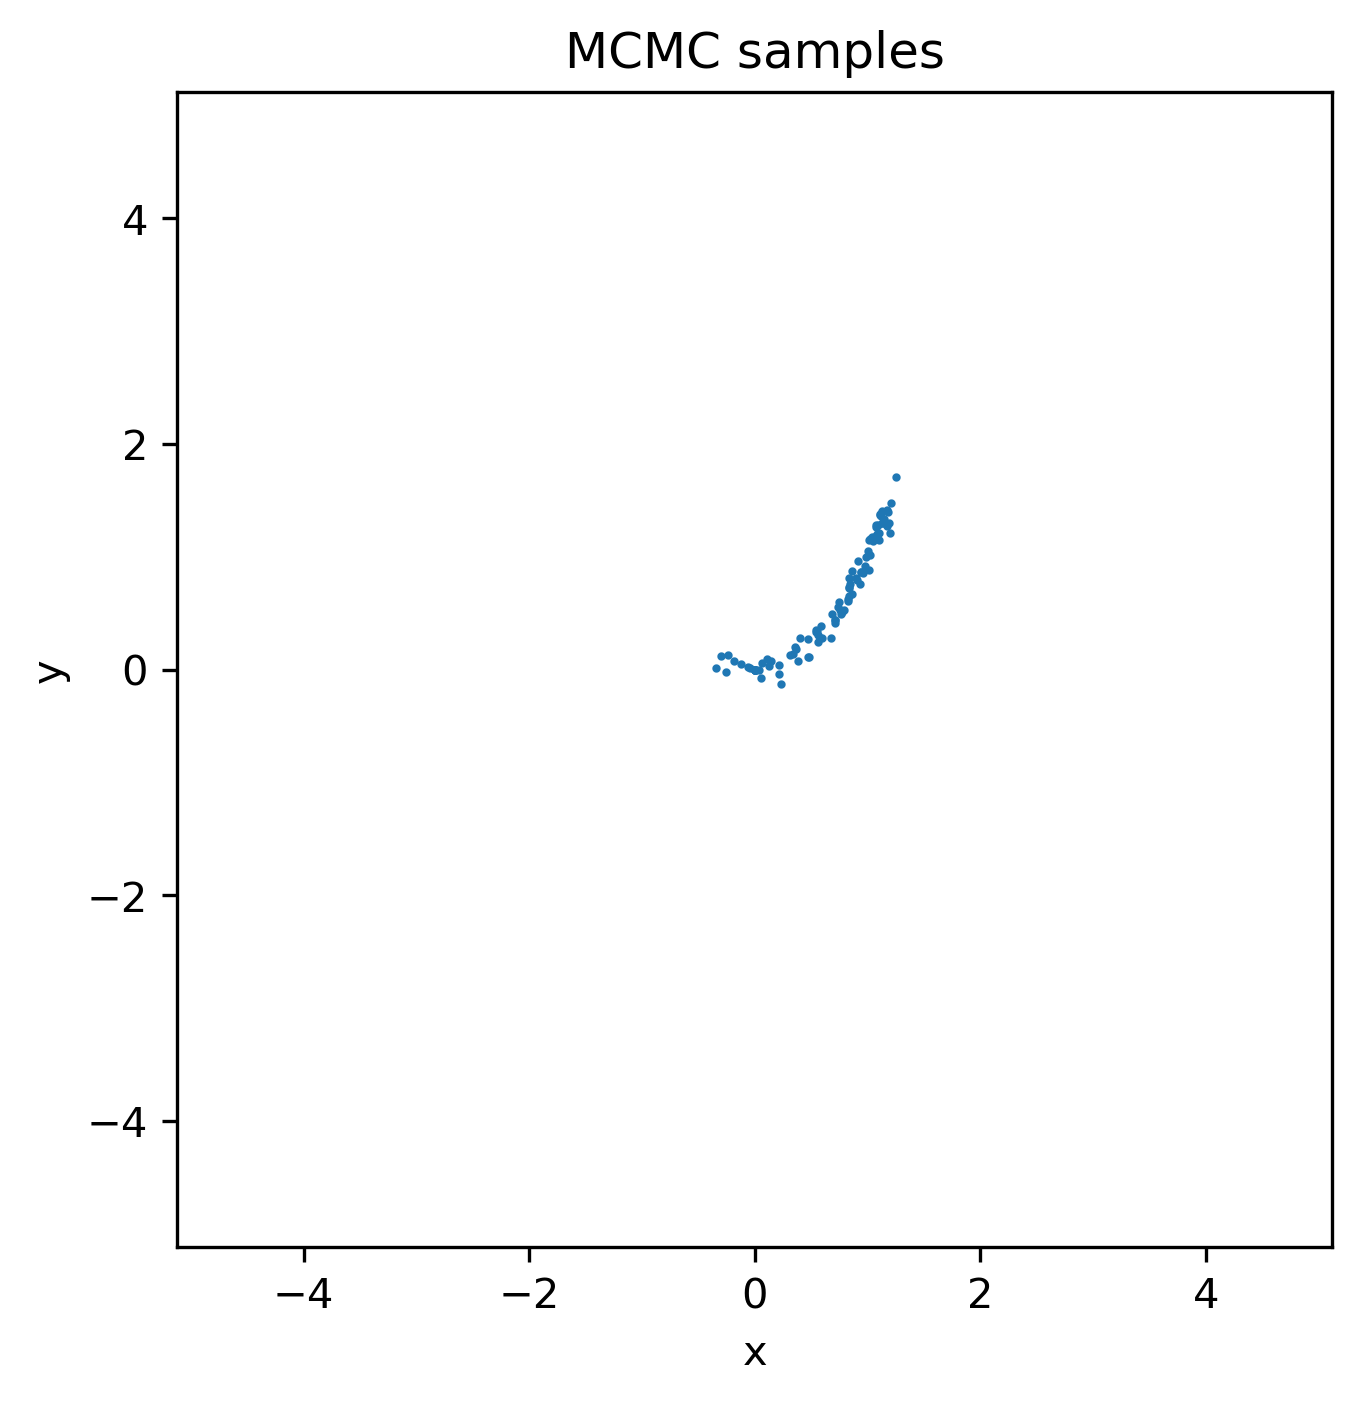

In [80]:
x0 = [[0.0, 0.0]]

sampler = mc.sampler.PerfectSampler(target, proposal, x0, seed=seed)

T, num_samples = 8, 100

samples = sampler.get_perfect_samples(T, num_samples, verbose=True)

fig, ax = plt.subplots(figsize=(5,5), dpi=300)
ax.scatter(samples[:, 0], samples[:, 1], s=1, c='C0')
ax.set_xlim(-5.12, 5.12)
ax.set_ylim(-5.12, 5.12)
ax.set_xlabel(f"x")
ax.set_ylabel(f"y")
ax.set_aspect('equal')
ax.set_title(f"MCMC samples")
plt.show()